<a href="https://colab.research.google.com/github/sakamototaisei/python_colab/blob/main/AI%E3%81%A7%E6%9D%A1%E4%BB%B6%E4%BB%98%E3%81%AE%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E3%82%92%E7%94%9F%E6%88%90_GAN%E3%81%A7%E5%AD%A6%E3%81%B6%E7%94%9F%E6%88%90%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **生成モデルについて**

## **画像認識との違い：識別モデルと生成モデル**

**識別モデル**

*   入力情報/画像に対して、どのクラスであるか予測

**生成モデル**

*   入力情報に画像や乱数を与え→生成モデル→出力情報を生み出す

## **生成モデルの種類Part1_オートエンコーダー**

**オートエンコーダー：自己符号化器**

*   入力と出力が同じ値に
*   ReLU関数により、事前学習は不要になった

## **生成モデルの種類Part2_VAE**

**VAE：変分自己符号化器**

*   出力が潜在変数によって決まる

## **生成モデルの種類Part3_GAN**

**GAN：敵対的生成ネットワーク**

*   「生成器」により偽物を生成し、本物と偽物を「識別器」によって判定する
*   「生成器」の学習によって、「識別器」が正しく判断できなくなる出力0.5を目指す

# **様々なGAN**

## **無垢に生まれたVanillaGAN**

*   最もシンプルなGAN

## **画像に強いDCGAN**

*   上記のニューラルネットワークの部分を畳み込み層に置き換えたもの(識別器、生成器)
*   解像度を4倍に増やしても、畳み込みの重み共有によりパラメータの数を減らすことができる、綺麗な画像を表現しつつ学習時間を短縮



## **条件付きのConditional GAN**

*   生成器や識別器に入力ノイズに条件を付ける、どの数字を生成しているのかなど

## **組み合わせのConditional DCGAN**

*   DCGANとConditionalv GANを組み合わせてもの

# **手書き文字を生み出そう：ソフトウェアコーディング**

## **ライブラリの読み込み**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
torch.__version__

'2.0.1+cu118'

## **データセットの読み込み**

In [4]:
# 画像サイズ
img_size = 32

# バッチサイズ、一度に学習できる画像の数になる
batch_size = 128

In [27]:
data_transforms = transforms.Compose(
    [
     transforms.Resize(img_size),
     transforms.ToTensor(),
     # RGBの場合は [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
     transforms.Normalize([0.5], [0.5])
     ]
)

train_datasets = datasets.MNIST(root="./datasets",
                                        train=True, download=True,
                                        transform=data_transforms)

loaders = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

In [28]:
next(iter(loaders))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [7]:
# 画像データの取得
next(iter(loaders))[0].shape

torch.Size([128, 1, 32, 32])

## **画像を表示させる**

In [8]:
def im_show(image):
    print(image.shape)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    im = image.detach().numpy()
    im = im.transpose(1, 2, 0) # c h w → h w c
    # ノーマライゼーションの処理、暗い画像明るい画像を均等にする
    im = std * im + mean
    plt.imshow(im)

torch.Size([1, 32, 32])


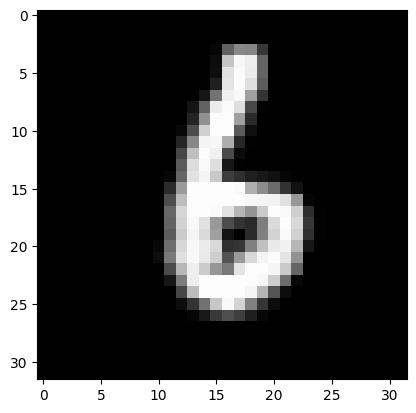

In [9]:
im_show(next(iter(loaders))[0][0])

## **入力ノイズの生成**

In [29]:
def create_noise(batch_size):
    # torch.randn() 正規分布を自動生成してくれるメソッド
    z = torch.randn((batch_size, 100, 1, 1)) # # 正規乱数 -3.0 〜 -3.0
    return z.cuda()

In [30]:
create_noise(1)

tensor([[[[ 1.6957]],

         [[ 0.6317]],

         [[ 1.2511]],

         [[ 0.3763]],

         [[ 0.4946]],

         [[ 0.2216]],

         [[ 0.4428]],

         [[ 0.6477]],

         [[ 0.2849]],

         [[-1.4172]],

         [[ 0.8311]],

         [[-0.7437]],

         [[ 0.1362]],

         [[-1.4422]],

         [[ 0.2872]],

         [[ 0.9321]],

         [[-1.5577]],

         [[ 0.1785]],

         [[-0.8278]],

         [[ 1.3585]],

         [[-0.5592]],

         [[-0.3690]],

         [[-1.2321]],

         [[-0.7125]],

         [[-0.5200]],

         [[ 1.0251]],

         [[ 1.0106]],

         [[-1.1270]],

         [[ 1.4140]],

         [[-0.2310]],

         [[-0.0224]],

         [[ 1.8734]],

         [[ 0.5684]],

         [[-1.0275]],

         [[-0.8497]],

         [[ 0.5564]],

         [[ 1.8505]],

         [[-0.3807]],

         [[ 0.2012]],

         [[-0.0943]],

         [[ 1.4738]],

         [[ 1.2928]],

         [[ 0.3337]],

         [[

In [31]:
z = create_noise(1)
print('max', z.max())
print('min', z.min())

max tensor(2.8304, device='cuda:0')
min tensor(-2.9114, device='cuda:0')


## **条件ラベルの生成**

In [32]:
# 生成器に使う単位行列
# Create one-hot vector
def create_1hot_vector():
    label_1hots = torch.zeros(10,10)
    for i in range(10):
        label_1hots[i,i] = 1
    label_1hots = label_1hots.view(10,10,1,1).cuda()
    return label_1hots

In [33]:
# 生成器に使う単位行列を生成
label_1hots = create_1hot_vector()
label_1hots.view(10, 10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [34]:
# 識別器に使う単位行列
# Create filled data for discriminator.
def create_filled_label():
    label_fills = torch.zeros(10, 10, img_size, img_size)
    ones = torch.ones(img_size, img_size)
    for i in range(10):
        label_fills[i][i] = ones
    return label_fills.cuda()

In [35]:
label_fills = create_filled_label()
label_fills[1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

## **Generatorの作成**

In [53]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # 入力チャンネルのベースとなる値を設定
        d = 128 # latent
        # 転置畳み込み
        self.deconv1s = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        # 画像情報の偏りをなくす
        self.deconv1s_bn = nn.BatchNorm2d(d*2)
        # ターゲットラベル
        self.deconv1t = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1t_bn = nn.BatchNorm2d(d*2)
        # ---　ここまでが入力層側のパラメータの設定 ---

        # 第二層上記2つを足し合わせて2倍になっている
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)

        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)

        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # 重みの初期化
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # 順伝播処理
    def forward(self, input_, label):
        x = F.relu(self.deconv1s_bn(self.deconv1s(input_)))
        y = F.relu(self.deconv1t_bn(self.deconv1t(label)))
        # xとyをチャンネル方向に足し合わせる
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))

        return x

In [54]:
Generator()

Generator(
  (deconv1s): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1s_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1t): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1t_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

## **Discriminatorの作成**

In [63]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 入力チャンネルを64と指定
        d = 64
        # Generatorと逆のことをしてくイメージ
        self.conv1s = nn.Conv2d(1, d, 4, 2, 1)
        self.conv1t = nn.Conv2d(10, d, 4, 2, 1)

        self.conv2 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*4)

        self.conv3 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*8)
        self.conv4 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input_, label):
        x = F.leaky_relu(self.conv1s(input_), 0.2)
        y = F.leaky_relu(self.conv1t(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))
        return x

In [64]:
Discriminator()

Discriminator(
  (conv1s): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1t): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

## **重みの初期化**

In [65]:
def normal_init(m, mean, std):
    # 転置畳み込みまたは畳み込みのモジュールであった場合に
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        # モジュールの重みのデータを正規化する
        m.weight.data.normal_(mean, std)
        # バイアスを0に初期化している
        m.bias.data.zero_()

In [66]:
sample = Generator()
# Generatorの転置畳み込み1層目の画像の重みを取得
w = sample.deconv1s.weight
print(w.max())
# 重みの初期化関数を呼び出す
sample.weight_init(mean=0.0, std=0.02)
print(w.max())
# 重みが大きくなる

tensor(0.0156, grad_fn=<MaxBackward1>)
tensor(0.1005, grad_fn=<MaxBackward1>)


## **インスタンス化**

In [67]:
# ハイパーパラメーターとして学習係数を定義
learning_rate = 0.0002

# 条件ラベルをインスタンス化
label_1hots = create_1hot_vector()
label_fills = create_filled_label()

# 学習モデルをインスタンス化
G = Generator().cuda()
D = Discriminator().cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

# 学習する上での最適化の処理を初期化する
optimizer_G = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# 損失関数を設定
BCE_loss = torch.nn.BCELoss()

In [68]:
#  Discriminatorの教師ラベル生成と自動微分化 Variable
t_real = Variable(torch.ones(batch_size)).cuda()
t_fake = Variable(torch.zeros(batch_size)).cuda()

# Train log
loss_list={}
loss_list['loss_G']=[]
loss_list['loss_D']=[]

## **学習ループ**

In [69]:
# ハイパーパラメーターの設定
epochs = 10

# 継続の場合は、途中の番号を設定
epoch_from = 1

In [70]:
# Train loop
for epoch in range(epoch_from, epochs + 1):
    print('epoch', epoch)
    # 画像データとその画像がどの数字であったかというセットを取得
    for i, (x_batch, t_batch) in enumerate(loaders):

        # 取得したミニバッチのサイズ
        N = len(x_batch)

        label_1hot = label_1hots[t_batch]
        label_fill = label_fills[t_batch]

        # Generatorの損失を計算
        # ノイズを作成
        z = create_noise(N)
        # 作り出したフェイク画像と、どの画像を作り出したかというラベルを与えて、これが本物であるか偽物であるか判定させる
        fake = G(z, label_1hot)
        # .squeeze()複雑な配列の要素を綺麗にまとまった形で成形して取り出す
        pred = D(fake, label_fill).squeeze()
        # 予測したpred変数が本当の値t_realとどれだけ誤差があるか計算
        loss_G = BCE_loss(pred, t_real[0:N])
        loss_list['loss_G'].append(loss_G)

        # Generatorの損失を元にパラメーターを更新
        # 勾配を初期化
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Discriminatorの本物と偽物の損失をそれぞれ計算
        # # 本物の損失を計算 本物の画像を取得
        real = Variable(x_batch).cuda()
        pred = D(real, label_fill).squeeze()
        loss_D_real = BCE_loss(pred, t_real[0:N])

        # 偽物の損失
        z = create_noise(N)
        # フェイク画像を取得
        fake = G(z, label_1hot)
        # フェイク画像をデタッチとして整形して入力する
        pred = D(fake.detach(), label_fill).squeeze()
        loss_D_fake = BCE_loss(pred, t_fake[0:N])

        # 2つの損失を足し合わせる
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_list['loss_D'].append(loss_D)

        # Discriminatorのパラメーターを更新する
        # 勾配を初期化
        optimizer_D.zero_grad()
        # 誤差逆伝播
        loss_D.backward()
        # パラメータの更新,
        optimizer_D.step()

        # 100回に1度ログを表示させる
        if i % 100 == 0:
            print('G: %.4f D: %.4f' %(loss_G, loss_D))

    epoch_from += 1

    # Learning rate decay
    if epoch==5:
        optimizer_D.param_groups[0]['lr'] = learning_rate/2
    elif epoch==7:
        optimizer_D.param_groups[0]['lr'] = learning_rate/4
    elif epoch==9:
        optimizer_D.param_groups[0]['lr'] = learning_rate/8

epoch 1
G: 0.2313 D: 1.8745
G: 5.8407 D: 0.6059
G: 2.4820 D: 0.4293
G: 2.2666 D: 0.3255
G: 2.5929 D: 0.2573
epoch 2
G: 3.4708 D: 0.2967
G: 2.0298 D: 0.3580
G: 1.9766 D: 0.3684
G: 0.7740 D: 0.5529
G: 2.0838 D: 0.4759
epoch 3
G: 0.7853 D: 0.7373
G: 0.7187 D: 0.5779
G: 1.3139 D: 0.4593
G: 0.9514 D: 0.5401
G: 0.8395 D: 0.5383
epoch 4
G: 2.4254 D: 0.5841
G: 2.5618 D: 0.6302
G: 2.3839 D: 0.6302
G: 2.8694 D: 0.7229
G: 0.4470 D: 0.7660
epoch 5
G: 0.4534 D: 0.7654
G: 0.9023 D: 0.5101
G: 2.1950 D: 0.5427
G: 1.3647 D: 0.4302
G: 1.0891 D: 0.4415
epoch 6
G: 1.0908 D: 0.3905
G: 2.1059 D: 0.3336
G: 2.0466 D: 0.3593
G: 2.4521 D: 0.3633
G: 2.0708 D: 0.3212
epoch 7
G: 2.1333 D: 0.3167
G: 2.5573 D: 0.4012
G: 3.2109 D: 0.4928
G: 1.0902 D: 0.3775
G: 1.2247 D: 0.3607
epoch 8
G: 2.4768 D: 0.3655
G: 1.8466 D: 0.2916
G: 1.8759 D: 0.2675
G: 2.4203 D: 0.3081
G: 2.4058 D: 0.3528
epoch 9
G: 1.7555 D: 0.2671
G: 2.1254 D: 0.2926
G: 1.8303 D: 0.3154
G: 1.8537 D: 0.3511
G: 2.7243 D: 0.3627
epoch 10
G: 2.0161 D: 0.3160

### **テストコードの作成**

In [75]:
# Labels for test
t_test = torch.zeros(100, dtype=int)
# どの画像を生成するか決めることができるようになる
n = 0
for i in range(100):
    t_test[i] = n
    if (i+1)%10 == 0:
        n += 1

In [76]:
# Exercise
t_test

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9])

In [73]:
# Test
def test():
    # バッチノーマイゼーションという正規化の処理をテスト用に指定することができる
    G.eval()
    # ノイズの作成
    z = create_noise(100)
    label_1hot = label_1hots[t_test]
    fake = G(z, label_1hot).cpu()
    return fake

torch.Size([1, 32, 32])


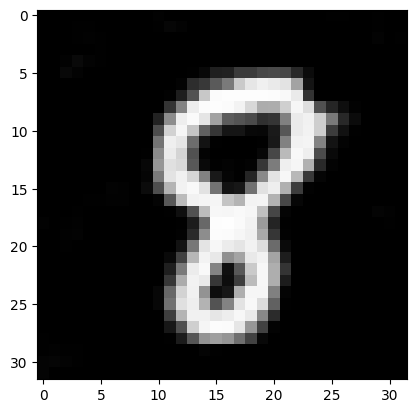

In [78]:
# Test
fake = test()
im_show(fake[80]) # 0-99

## **一覧表示をしてみよう**

In [81]:
# Layout
def im_layout(images):
    print(images.shape)

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    im = images.detach().numpy()
    # 画像配列の形態をを変更
    im = im.transpose(0, 2, 3, 1) # c h w -> h w c
    # 画像のノーマライズ
    im = std * im + mean

    plt.figure(figsize=(10,10))

    row = 10
    col = 10
    n = 0
    while n < row * col:
        n += 1
        plt.subplot(row, col, n)
        plt.imshow(im[n-1])
        plt.axis('off')

torch.Size([100, 1, 32, 32])


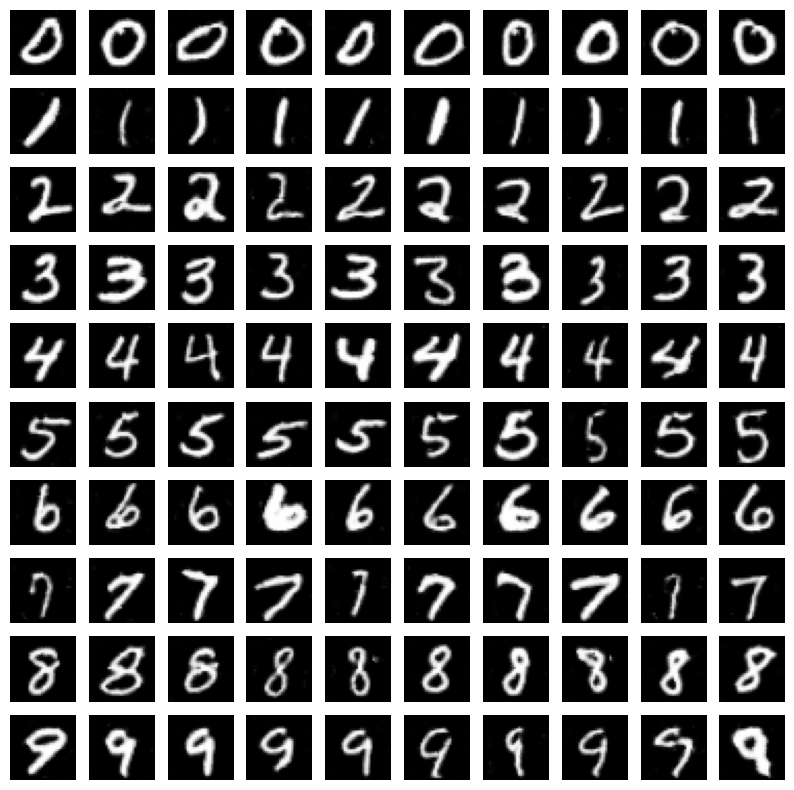

In [82]:
im_layout(test())